In [ ]:
!unzip /content/Spectro_Dataset.zip

In [ ]:
import matplotlib.pyplot as plt
import torch
import random
from collections import Counter
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
#defining all data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
#Loading the datasets
train_dataset = ImageFolder(root='/content/Spectro_Dataset/Specto_train', transform=transform)
val_dataset = ImageFolder(root='/content/Spectro_Dataset/Spectro_Val', transform=transform)
test_dataset = ImageFolder(root='/content/Spectro_Dataset/Spectro_test', transform=transform)

In [ ]:
print(f"Classes: {train_dataset.classes}")

Classes: ['Ambulance', 'Road']


In [ ]:
LABELS = train_dataset.classes

['Ambulance', 'Road']

In [ ]:
#creating data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
#check distribution
train_classes = [train_dataset.targets[i] for i in range(len(train_dataset))]
print("Class distribution in training set:", Counter(train_classes))

Class distribution in training set: Counter({0: 644, 1: 630})


Batch size: torch.Size([32, 3, 224, 224])
Labels: tensor([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 1, 0])


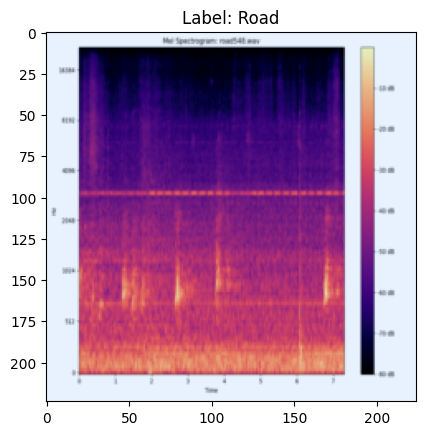

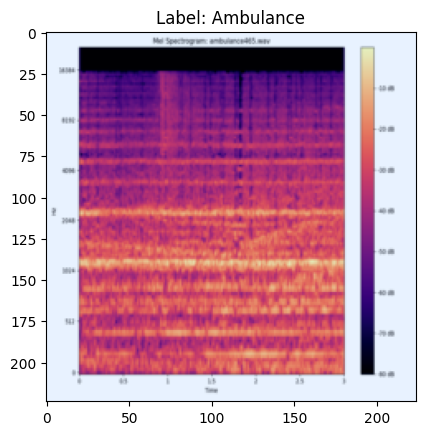

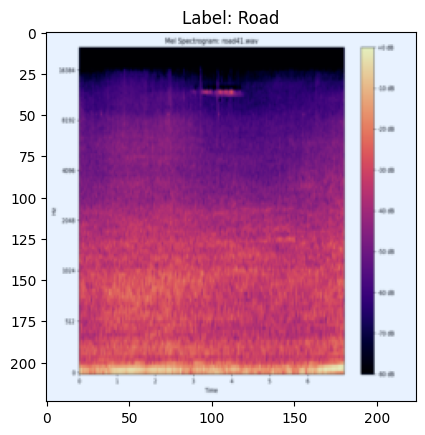

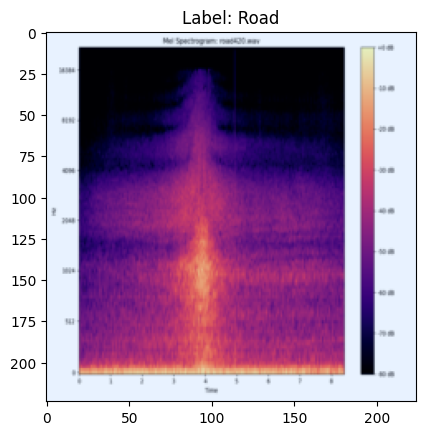

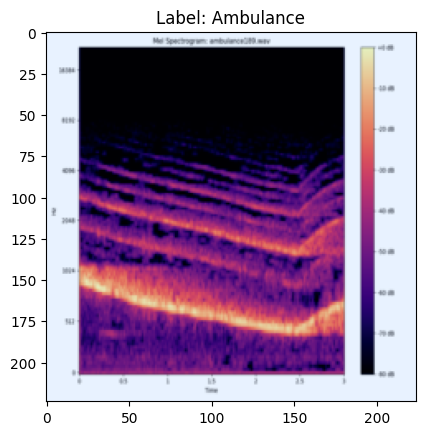

In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
print("Batch size:", images.shape)
print("Labels:", labels)

#displaying the first 5 images
for i in range(5):
    #denormalization
    plt.imshow(images[i].permute(1, 2, 0).numpy() * 0.225 + 0.406)
    plt.title(f"Label: {LABELS[labels[i]]}")
    plt.show()


In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

#loading the model with the pretrained weights
model = resnet18(pretrained=True)
#displaying the model architecture
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 63.3MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#get num of features on the last layer
n_features= model.fc.in_features
#activation =sigmoid
model.fc = nn.Sequential(nn.Linear(n_features, 1), nn.Sigmoid())

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
device

device(type='cuda')

In [ ]:
#feature extraction phase
#freezing the previous layers to prevent backpropogation
for param in model.parameters():
    param.requires_grad = False
#unfreezing the last layers to allow backpropogation
for param in model.fc.parameters():
    param.requires_grad = True

In [ ]:
criterion = nn.BCELoss()
#optimizer = Adam, with learning rate =1e-4
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float().view(-1, 1)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        #converting result to either 0 or 1
        predicted = (outputs > 0.5).int()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_acc = 100 * correct_train / total_train
    train_accuracies.append(train_acc)

    #setting model to validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    #witout computing gradients
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().view(-1, 1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            predicted = (outputs > 0.5).int()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc = 100 * correct_val / total_val
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/20, Train Loss: 0.6416, Train Acc: 66.95%, Val Loss: 0.6568, Val Acc: 64.29%
Epoch 2/20, Train Loss: 0.5978, Train Acc: 75.12%, Val Loss: 0.6144, Val Acc: 73.21%
Epoch 3/20, Train Loss: 0.5589, Train Acc: 81.63%, Val Loss: 0.5868, Val Acc: 78.21%
Epoch 4/20, Train Loss: 0.5207, Train Acc: 85.24%, Val Loss: 0.5575, Val Acc: 85.00%
Epoch 5/20, Train Loss: 0.4916, Train Acc: 88.85%, Val Loss: 0.5322, Val Acc: 86.43%
Epoch 6/20, Train Loss: 0.4639, Train Acc: 89.40%, Val Loss: 0.5100, Val Acc: 88.93%
Epoch 7/20, Train Loss: 0.4390, Train Acc: 90.19%, Val Loss: 0.4859, Val Acc: 91.43%
Epoch 8/20, Train Loss: 0.4183, Train Acc: 91.13%, Val Loss: 0.4751, Val Acc: 91.43%
Epoch 9/20, Train Loss: 0.4013, Train Acc: 91.76%, Val Loss: 0.4509, Val Acc: 91.79%
Epoch 10/20, Train Loss: 0.3843, Train Acc: 91.60%, Val Loss: 0.4371, Val Acc: 92.50%
Epoch 11/20, Train Loss: 0.3722, Train Acc: 91.99%, Val Loss: 0.4223, Val Acc: 93.57%
Epoch 12/20, Train Loss: 0.3633, Train Acc: 92.39%, Val Loss: 0

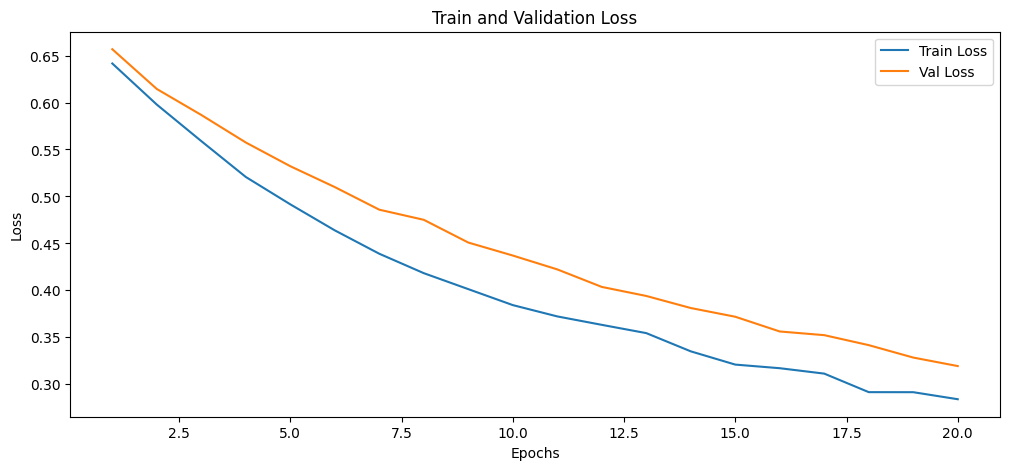

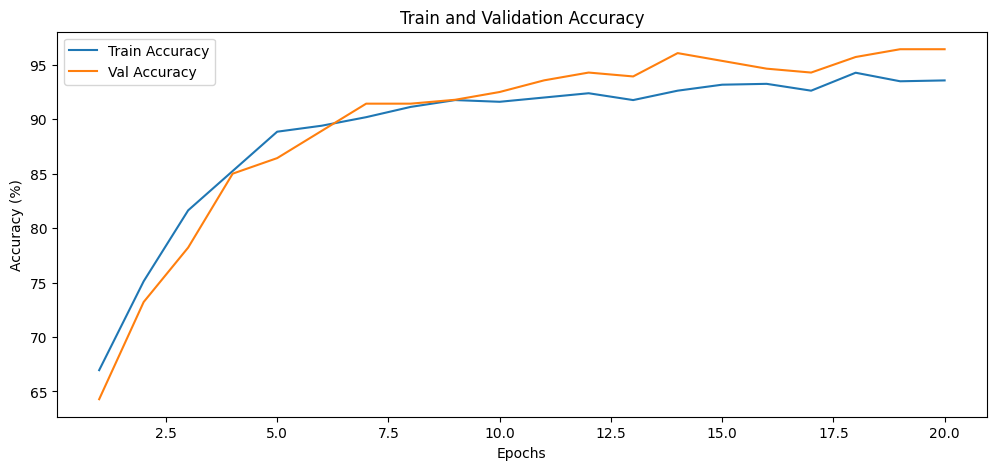

In [ ]:

# Plot losses
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plot accuracies
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
#unfreezing the previous layers
for param in model.parameters():
    param.requires_grad = True

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    #training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float().view(-1, 1)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


        predicted = (outputs > 0.5).int()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_acc = 100 * correct_train / total_train
    train_accuracies.append(train_acc)

    #validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().view(-1, 1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            predicted = (outputs > 0.5).int()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc = 100 * correct_val / total_val
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/5, Train Loss: 0.0819, Train Acc: 97.02%, Val Loss: 0.0017, Val Acc: 100.00%
Epoch 2/5, Train Loss: 0.0017, Train Acc: 100.00%, Val Loss: 0.0013, Val Acc: 100.00%
Epoch 3/5, Train Loss: 0.0007, Train Acc: 100.00%, Val Loss: 0.0005, Val Acc: 100.00%
Epoch 4/5, Train Loss: 0.0005, Train Acc: 100.00%, Val Loss: 0.0005, Val Acc: 100.00%
Epoch 5/5, Train Loss: 0.0004, Train Acc: 100.00%, Val Loss: 0.0003, Val Acc: 100.00%


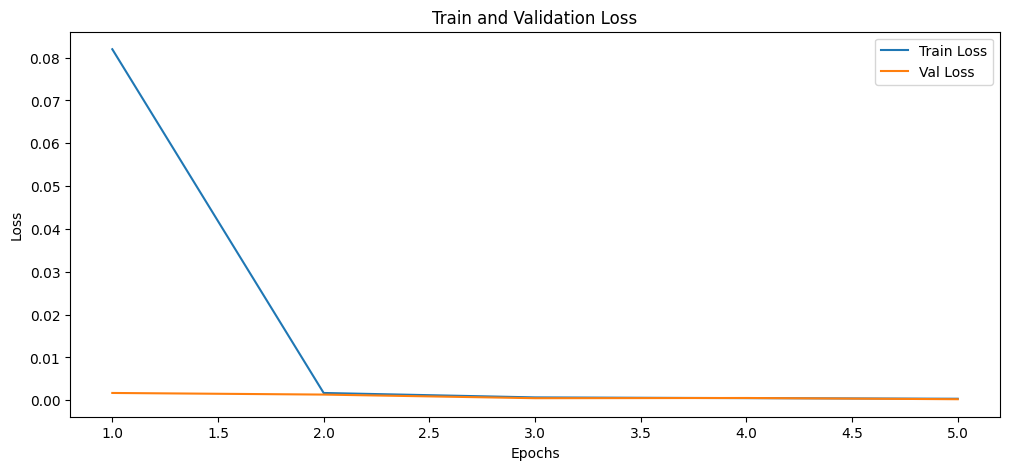

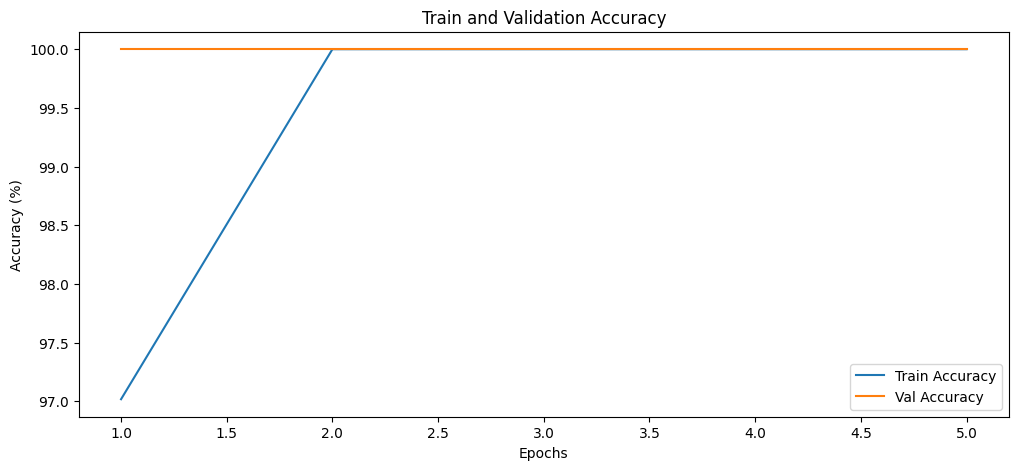

In [ ]:

# Plot losses
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plot accuracies
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
# Put the model in evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
y_pred = []
y_label = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float().view(-1, 1)
        outputs = model(inputs)

        predicted = (outputs > 0.5).int()


        y_pred.extend(predicted.cpu().numpy())
        y_label.extend(labels.cpu().numpy())

#converison to numpy for visualizing
y_preds = np.array(all_preds)
y_label = np.array(all_labels)


              precision    recall  f1-score   support

   Ambulance       1.00      1.00      1.00       148
        Road       1.00      1.00      1.00       139

    accuracy                           1.00       287
   macro avg       1.00      1.00      1.00       287
weighted avg       1.00      1.00      1.00       287

Confusion Matrix:
[[148   0]
 [  0 139]]


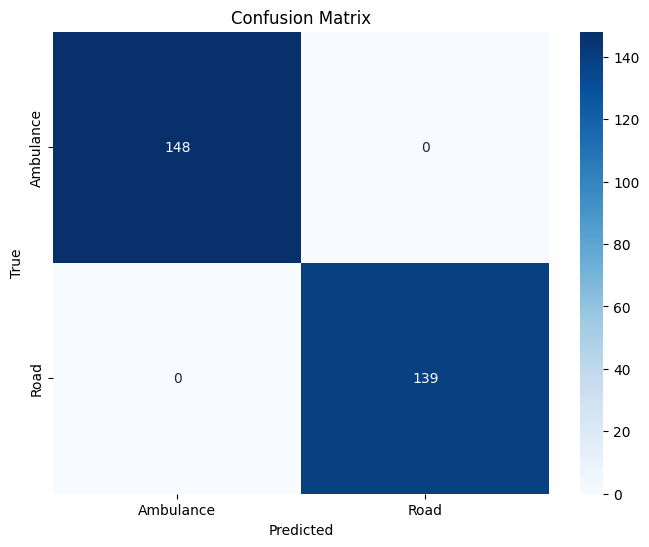

In [ ]:
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()